In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, validation_curve, learning_curve, LearningCurveDisplay, ShuffleSplit

In [25]:
train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

original = pd.read_csv("/kaggle/input/bank-marketing-dataset-full/bank-full.csv", sep=';')

In [3]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')

# Initial classification
categorical = []
numerical = []
boolean = []

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if df[col].dtype == 'object':
        # Check if only 'yes'/'no' or 'true'/'false'
        if set(unique_vals).issubset({'yes', 'no', 'true', 'false', 'True', 'False'}):
            boolean.append(col)
        else:
            categorical.append(col)
    elif pd.api.types.is_numeric_dtype(df[col]):
        if len(unique_vals) == 2:
            boolean.append(col)
        else:
            numerical.append(col)
    else:
        categorical.append(col)

print("Categorical columns:", categorical)
print("Numerical columns:", numerical)
print("Boolean columns:", boolean)

Categorical columns: ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
Numerical columns: ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Boolean columns: ['default', 'housing', 'loan', 'y']


In [5]:
Categorical_columns =  ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
Numerical_columns = ['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Boolean_columns = ['default', 'housing', 'loan', 'y']

In [6]:
train.shape

(750000, 18)

In [7]:
train.replace('unknown', np.nan, inplace=True)

<Axes: >

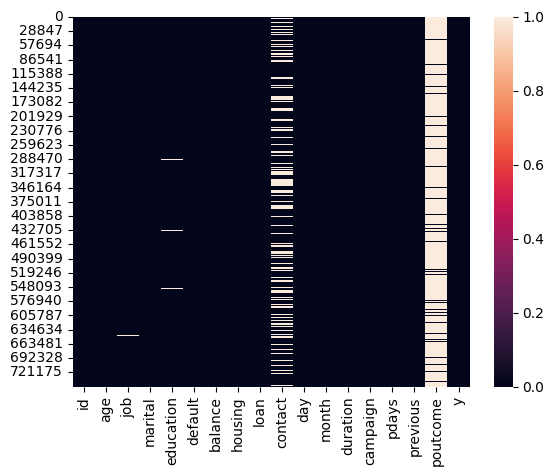

In [8]:
import seaborn as sns
sns.heatmap(train.isnull())

In [9]:
train.drop(['poutcome', 'contact'], axis=1, inplace=True, errors='ignore')


In [10]:
print("Unique values in original['y']:", original["y"].unique())
print("Unique values in train['y']:", train["y"].unique())

train = train.drop(columns=["id"])

original["y"] = original["y"].map({"no": 0, "yes": 1})

original = original[train.columns]

merged = pd.concat([train, original], ignore_index=True)

print("Merged shape:", merged.shape)
print("Merged target distribution:\n", merged["y"].value_counts())


Unique values in original['y']: ['no' 'yes']
Unique values in train['y']: [0 1]
Merged shape: (795211, 15)
Merged target distribution:
 y
0    699434
1     95777
Name: count, dtype: int64


In [11]:
print(merged.dtypes)

numeric_cols = merged.select_dtypes(include=["int64", "float64"]).columns.tolist()

categorical_cols = merged.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
y             int64
dtype: object
Numeric features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']
Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month']


In [12]:
missing_values = merged.isnull().sum()

missing_values = missing_values[missing_values > 0]

print("Missing values:\n", missing_values)

Missing values:
 job           2917
education    21299
dtype: int64


In [13]:
categorical_cols = merged.select_dtypes(include=["object"]).columns

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    merged[col] = le.fit_transform(merged[col])
    label_encoders[col] = le

In [14]:
X = merged.drop(columns=["y"])
# x_train.drop(['campaign','contact'],axis =1 ,inplace = True)

y = merged["y"]

In [15]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# y_probs = np.zeros(len(X_test))

fold = 1
for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        n_estimators=25000, 
        learning_rate=0.05,
        min_child_samples=9,
        subsample=0.8,
        colsample_bytree=0.5,
        num_leaves=100,
        max_depth=10,
        max_bin=4523,
        reg_alpha=0.79,
        reg_lambda=3,
    )
    
    model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_val, y_val)], 
        callbacks=[
            lgb.early_stopping(300),
            lgb.log_evaluation(period=50)
        ]
    )

    # y_probs += model.predict_proba(X_test)[:, 1] / n_splits
    
    preds_class = model.predict(X_val)
    preds_proba = model.predict_proba(X_val)[:, 1]  

    acc = accuracy_score(y_val, preds_class)
    auc = roc_auc_score(y_val, preds_proba)

    print(f"Fold {fold} - Accuracy: {acc:.4f} - ROC AUC: {auc:.4f}")
    fold += 1

Training until validation scores don't improve for 300 rounds
[50]	valid_0's binary_logloss: 0.187337
[100]	valid_0's binary_logloss: 0.164157
[150]	valid_0's binary_logloss: 0.156417
[200]	valid_0's binary_logloss: 0.152572
[250]	valid_0's binary_logloss: 0.150241
[300]	valid_0's binary_logloss: 0.148613
[350]	valid_0's binary_logloss: 0.147293
[400]	valid_0's binary_logloss: 0.146231
[450]	valid_0's binary_logloss: 0.145289
[500]	valid_0's binary_logloss: 0.144563
[550]	valid_0's binary_logloss: 0.143921
[600]	valid_0's binary_logloss: 0.143203
[650]	valid_0's binary_logloss: 0.142515
[700]	valid_0's binary_logloss: 0.142059
[750]	valid_0's binary_logloss: 0.141665
[800]	valid_0's binary_logloss: 0.141279
[850]	valid_0's binary_logloss: 0.140925
[900]	valid_0's binary_logloss: 0.140658
[950]	valid_0's binary_logloss: 0.140391
[1000]	valid_0's binary_logloss: 0.139932
[1050]	valid_0's binary_logloss: 0.139636
[1100]	valid_0's binary_logloss: 0.13936
[1150]	valid_0's binary_logloss: 0.

In [21]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,32,1,1,1,0,1397,1,0,unknown,21,8,224,1,-1,0,unknown
1,44,4,1,2,0,23,1,0,cellular,3,0,586,2,-1,0,unknown
2,36,6,1,0,0,46,1,1,cellular,13,8,111,2,-1,0,unknown
3,58,1,1,1,0,-1380,1,1,unknown,29,8,125,1,-1,0,unknown
4,28,9,2,1,0,1950,1,0,cellular,22,5,181,1,-1,0,unknown


In [26]:
test_id = test["id"]  # Save for submission
test = test.drop(columns=["id"])
test.drop(['poutcome','contact'],axis =1 ,inplace = True)

for col in categorical_cols:
    le = label_encoders[col]
    test[col] = le.transform(test[col])  # same categories as train

X_final = merged.drop(columns=["y"])
y_final = merged["y"]

final_model = lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1,
        n_estimators=25000, 
        learning_rate=0.05,
        min_child_samples=9,
        subsample=0.8,
        colsample_bytree=0.5,
        num_leaves=100,
        max_depth=10,
        max_bin=4523,
        reg_alpha=0.79,
        reg_lambda=3,
    )

final_model.fit(
        X_final, y_final,
        eval_set=[(X_final, y_final)],
        callbacks=[
            lgb.early_stopping(300),
            lgb.log_evaluation(period=50)
        ]
    )

test_preds_proba = final_model.predict_proba(test)[:, 1]

submission = pd.DataFrame({
    "id": test_id,
    "y": test_preds_proba
})

submission.to_csv("submission.csv", index=False)
print(" submission.csv file created")

/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:341: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[50]	training's binary_logloss: 0.18658
[100]	training's binary_logloss: 0.163158
[150]	training's binary_logloss: 0.154622
[200]	training's binary_logloss: 0.150012
[250]	training's binary_logloss: 0.146741
[300]	training's binary_logloss: 0.144204
[350]	training's binary_logloss: 0.142043
[400]	training's binary_logloss: 0.140456
[450]	training's binary_logloss: 0.138987
[500]	training's binary_logloss: 0.137532
[550]	training's binary_logloss: 0.136074
[600]	training's binary_logloss: 0.13486
[650]	training's binary_logloss: 0.133782
[700]	training's binary_logloss: 0.132582
[750]	training's binary_logloss: 0.131484
[800]	training's binary_logloss: 0.130381
[850]	training's binary_logloss: 0.129367
[900]	training's binary_logloss: 0.128448
[950]	training's binary_logloss: 0.127538
[1000]	training's binary_logloss: 0.126631
[1050]	training's binary_logloss: 0.125768
[1100]	training's binary_logloss: 0.12492
[1150]	training's binary_logloss: 0.124048
[1200]	training's binary_logloss: 

In [27]:
print(submission.head())


       id             y
0  750000  2.228115e-03
1  750001  2.991156e-02
2  750002  3.981576e-06
3  750003  4.641159e-07
4  750004  2.553053e-03
